In [ ]:
!pip install emot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import re
from emot.emo_unicode import UNICODE_EMOJI
from __future__ import unicode_literals
import operator
import sys

try:
    from html.parser import HTMLParser
except ImportError:
    from HTMLParser import HTMLParser

try:
    import html
except ImportError:
    pass

# Load Data

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Data/ViHSD/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Data/ViHSD/test.csv")
dev = pd.read_csv("/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Data/ViHSD/dev.csv")

In [ ]:
data = pd.concat([train['free_text'],test['free_text'],dev['free_text']]).reset_index(drop=True)
data = data[:3400]
data

0       Em được làm fan cứng luôn rồi nè ❤️ reaction q...
1       Đúng là bọn mắt híp lò xo thụt :))) bên việt n...
2                Đậu Văn Cường giờ giống thằng sida hơn à
3       CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...
4       Từ lý thuyết đến thực hành là cả 1 câu chuyện ...
                              ...                        
2995           Nhìn cái mặt Trần cọp là thấy hài rồi hhhh
2996        Ơ post này không thấy cà khịa anh Bom nhỉ :))
2997                                                    😮
2998                       Này chắc là chị của anh độ hỉ.
2999                Thầy tui còn đi đóng phim nữa mờ :)))
Name: free_text, Length: 3000, dtype: object

In [ ]:
data[685].lower()

'coi cái này nè : thành viên facebook thân mến, facebook là giả sử để được đóng cửa. gần đây, nó đang trở nên quá đông. đã có nhiều thành viên phàn nàn rằng facebook đang trở nên rất chậm. hồ sơ cho thấy rằng có rất nhiều thành viên facebook hoạt động v'

In [ ]:
emoji_list = list(UNICODE_EMOJI)

In [ ]:
''.join((' {} '.format(el) if el in emoji_list else el for el in data[570]))

'Không hiểu clg đang sảy ra 😶 '

# Tokenization Fuction

In [ ]:
def regex_or(*items):
    return '(?:' + '|'.join(items) + ')'

In [ ]:
punctChars = r"['\"“”‘’.?!…,:;]"
#punctSeq   = punctChars+"+"	#'anthem'. => ' anthem '.
punctSeq   = r"['\"“”‘’]+|[.?!,…]+|[:;]+"	#'anthem'. => ' anthem ' .
entity     = r"&(?:amp|lt|gt|quot);"

#URLs
urlStart1  = r"(?:https?://|\bwww\.)"
commonTLDs = r"(?:com|org|edu|gov|net|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|pro|tel|travel|xxx)"
ccTLDs	 = r"(?:ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|" + \
r"bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|" + \
r"er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|" + \
r"hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|" + \
r"lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|" + \
r"nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|sk|" + \
r"sl|sm|sn|so|sr|ss|st|su|sv|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|" + \
r"va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|za|zm|zw)"	#TODO: remove obscure country domains?
urlStart2  = r"\b(?:[A-Za-z\d-])+(?:\.[A-Za-z0-9]+){0,3}\." + regex_or(commonTLDs, ccTLDs) + r"(?:\."+ccTLDs+r")?(?=\W|$)"
urlBody    = r"(?:[^\.\s<>][^\s<>]*?)?"
urlExtraCrapBeforeEnd = regex_or(punctChars, entity) + "+?"
urlEnd     = r"(?:\.\.+|[<>]|\s|$)"
url        = regex_or(urlStart1, urlStart2) + urlBody + "(?=(?:"+urlExtraCrapBeforeEnd+")?"+urlEnd+")"

# Numeric
timeLike   = r"\d+(?::\d+){1,2}"  # (1:00:00)
numdotNum = r"\d+\.\d+"
rationum = r"\d+\-\d+"
numberWithCommas = r"(?:(?<!\d)\d{1,3},)+?\d{3}" + r"(?=(?:[^,\d]|$))"  #(1,5  2,5)
#currency
numComb	 = u"[\u0024\u058f\u060b\u09f2\u09f3\u09fb\u0af1\u0bf9\u0e3f\u17db\ua838\ufdfc\ufe69\uff04\uffe0\uffe1\uffe5\uffe6\u00a2-\u00a5\u20a0-\u20b9]?\\d+(?:\\.\\d+)+%?"

boundaryNotDot = regex_or("$", r"\s", r"[“\"?!,:;]", entity)
separators  = "(?:--+|―|—|~|–|=)"
decorations = u"(?:[♫♪]+|[★☆]+|[♥❤♡]+|[\u2639-\u263b]+|[\ue001-\uebbb]+)"
thingsThatSplitWords = r"[^\s\.,?\"]"


#  Emoticons
# myleott: in Python the (?iu) flags affect the whole expression
#normalEyes = "(?iu)[:=]" # 8 and x are eyes but cause problems
normalEyes = "[:=]" # 8 and x are eyes but cause problems
wink = "[;]"
noseArea = "(?:|-|[^a-zA-Z0-9 ])" # doesn't get :'-(
happyMouths = r"[D\)\]\}\>]+"
sadMouths = r"[\(\[\{\<]+"
tongue = "[pPd3*]+"
otherMouths = r"(?:[oO]+|[/\\]+|[vV]+|[Ss]+|[|]+)" # remove forward slash if http://'s aren't cleaned
bfLeft = u"(♥|0|[oO]|°|[vV]|\\$|[tT]|[xX]|;|\u0ca0|@|ʘ|•|・|◕|\\^|¬|\\*)"
bfCenter = r"(?:[\.]|[_-]+)"
bfRight = r"\2"
s3 = r"(?:--['\"])"
s4 = r"(?:<|&lt;|>|&gt;)[\._-]+(?:<|&lt;|>|&gt;)"
s5 = "(?:[.][_]+[.])"

double_eyes = r"(?:[^]" + r"[^])"
basicface = "(?:" +bfLeft+bfCenter+bfRight+ ")|" +s3+ "|" +s4+ "|" + s5
eeLeft = r"[＼\\ƪԄ\(（<>;ヽ\-=~\*]+"
eeRight= u"[\\-=\\);'\u0022<>ʃ）/／ノﾉ丿╯σっµ~\\*]+"
eeSymbol = r"[^A-Za-z0-9\s\(\)\*:=-]"
eastEmote = eeLeft + "(?:"+basicface+"|" +eeSymbol+")+" + eeRight
oOEmote = r"(?:[oO]" + bfCenter + r"[oO])"

Hearts = "(?:<+/?3+)+"
Arrows = regex_or(r"(?:<*[-―—=]*>+|<+[-―—=]*>*)", u"[\u2190-\u21ff]+")
Hashtag = "#[a-zA-Z0-9_ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚĂĐĨŨƠàáâãèéêìíòóôõùúăđĩũơƯĂẠẢẤẦẨẪẬẮẰẲẴẶẸẺẼỀỀỂưăạảấầẩẫậắằẳẵặẹẻẽềềểỄỆỈỊỌỎỐỒỔỖỘỚỜỞỠỢỤỦỨỪễếệỉịọỏốồổỗộớờởỡợụủứừỬỮỰỲỴÝỶỸửữựỳỵỷỹ]+"
AtMention = "[@＠][a-zA-Z0-9_ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚĂĐĨŨƠàáâãèéêìíòóôõùúăđĩũơƯĂẠẢẤẦẨẪẬẮẰẲẴẶẸẺẼỀỀỂưăạảấầẩẫậắằẳẵặẹẻẽềềểỄỆỈỊỌỎỐỒỔỖỘỚỜỞỠỢỤỦỨỪễếệỉịọỏốồổỗộớờởỡợụủứừỬỮỰỲỴÝỶỸửữựỳỵỷỹ]+"
Bound = r"(?:\W|^|$)"
Email = regex_or("(?<=(?:\W))", "(?<=(?:^))") + r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,4}(?=" +Bound+")"

# Edge punctuation
edgePunctChars    = u"'\"“”‘’«»{}\\(\\)\\[\\]\\*&" #add \\p{So}? (symbols)
edgePunct    = "[" + edgePunctChars + "]"
notEdgePunct = "[a-zA-Z0-9_ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚĂĐĨŨƠàáâãèéêìíòóôõùúăđĩũơƯĂẠẢẤẦẨẪẬẮẰẲẴẶẸẺẼỀỀỂưăạảấầẩẫậắằẳẵặẹẻẽềềểỄỆỈỊỌỎỐỒỔỖỘỚỜỞỠỢỤỦỨỪễếệỉịọỏốồổỗộớờởỡợụủứừỬỮỰỲỴÝỶỸửữựỳỵỷỹ]" # content characters
offEdge = r"(^|$|:|;|\s|\.|,)"  # colon here gets "(hello):" ==> "( hello ):"
EdgePunctLeft  = re.compile(offEdge + "("+edgePunct+"+)("+notEdgePunct+")", re.UNICODE)
EdgePunctRight = re.compile("("+notEdgePunct+")("+edgePunct+"+)" + offEdge, re.UNICODE)

In [ ]:
emoticon = regex_or(
        # Standard version  :) :( :] :D :P
        "(?:>|&gt;)?" + regex_or(normalEyes, wink) + regex_or(noseArea,"[Oo]") + regex_or(tongue+r"(?=\W|$|RT|rt|Rt)", otherMouths+r"(?=\W|$|RT|rt|Rt)", sadMouths, happyMouths),

        # reversed version (: D:  use positive lookbehind to remove "(word):"
        # because eyes on the right side is more ambiguous with the standard usage of : ;
        regex_or("(?<=(?: ))", "(?<=(?:^))") + regex_or(sadMouths,happyMouths,otherMouths) + noseArea + regex_or(normalEyes, wink) + "(?:<|&lt;)?",

        #inspired by http://en.wikipedia.org/wiki/User:Scapler/emoticons#East_Asian_style
        eastEmote.replace("2", "1", 1), basicface,
        # iOS 'emoji' characters (some smileys, some symbols) [\ue001-\uebbb]
        # TODO should try a big precompiled lexicon from Wikipedia, Dan Ramage told me (BTO) he does this

        # myleott: o.O and O.o are two of the biggest sources of differences
        #          between this and the Java version. One little hack won't hurt...
        oOEmote
)

In [ ]:
# m/d/yyyy + mm/dd/yyyy
d1 = r"^(1[0-2]|0?[1-9])/(3[01]|[12][0-9]|0?[1-9])/(?:[0-9]{2})?[0-9]{2}$"
# d/m/yyyy + dd/mm/yyyy
d2 = r"^(3[01]|[12][0-9]|0?[1-9])/(1[0-2]|0?[1-9])/(?:[0-9]{2})?[0-9]{2}$"
# m/d or mm/dd
d3 = r"^(1[0-2]|0?[1-9])/(3[01]|[12][0-9]|0?[1-9])"
# d/m or dd/mm
d4 = r"^(3[01]|[12][0-9]|0?[1-9])/(1[0-2]|0?[1-9])"

date = regex_or(d1,d2,d3,d4)

In [ ]:
# We will be tokenizing using these regexps as delimiters
# Additionally, these things are "protected", meaning they shouldn't be further split themselves.
Protected  = re.compile(
    regex_or(
        Hearts,
        url,
        Email,
        timeLike,
        date,
        numdotNum,
        rationum,
        numberWithCommas,
        numComb,
        emoticon,
        Arrows,
        entity,
        punctSeq,
        separators,
        decorations,
        Hashtag,
        AtMention), re.UNICODE)

In [ ]:
dict_map = {
    "òa": "oà",
    "Òa": "Oà",
    "ÒA": "OÀ",
    "óa": "oá",
    "Óa": "Oá",
    "ÓA": "OÁ",
    "ỏa": "oả",
    "Ỏa": "Oả",
    "ỎA": "OẢ",
    "õa": "oã",
    "Õa": "Oã",
    "ÕA": "OÃ",
    "ọa": "oạ",
    "Ọa": "Oạ",
    "ỌA": "OẠ",
    "òe": "oè",
    "Òe": "Oè",
    "ÒE": "OÈ",
    "óe": "oé",
    "Óe": "Oé",
    "ÓE": "OÉ",
    "ỏe": "oẻ",
    "Ỏe": "Oẻ",
    "ỎE": "OẺ",
    "õe": "oẽ",
    "Õe": "Oẽ",
    "ÕE": "OẼ",
    "ọe": "oẹ",
    "Ọe": "Oẹ",
    "ỌE": "OẸ",
    "ùy": "uỳ",
    "Ùy": "Uỳ",
    "ÙY": "UỲ",
    "úy": "uý",
    "Úy": "Uý",
    "ÚY": "UÝ",
    "ủy": "uỷ",
    "Ủy": "Uỷ",
    "ỦY": "UỶ",
    "ũy": "uỹ",
    "Ũy": "Uỹ",
    "ŨY": "UỸ",
    "ụy": "uỵ",
    "Ụy": "Uỵ",
    "ỤY": "UỴ",
    }

def replace_all(text, dict_map):
    for i, j in dict_map.items():
        text = text.replace(j, i)
    return text

In [ ]:
def splitEdgePunct(input):
    input = EdgePunctLeft.sub(r"\1\2 \3", input)
    input = EdgePunctRight.sub(r"\1 \2\3", input)
    return input

def addAllnonempty(master, smaller):
    for s in smaller:
        strim = s.strip()
        if (len(strim) > 0):
            master.append(strim)
    return master

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

def split_emoji_text(text):
    result = ''.join((' {} '.format(el) if el in emoji_list else el for el in text))
    return result


def split_emoji_emoji(textArray):
    result = []
    for word in textArray:
        is_emoji = False

        # iterate element of characters and check char is emoji if yes
        # then append into result list and set is_emogi flag true.
        for char in word:
            if char in [*emoji_list]:
                result.append(char)
                is_emoji = True

        # check is_emoji flag is false then append string into list.
        if not is_emoji:
            result.append(word)

    return result

def simpleTokenize(text):

    # Do the no-brainers first
    splitPunctText = splitEdgePunct(text)

    textLength = len(splitPunctText)

    # BTO: the logic here got quite convoluted via the Scala porting detour
    # It would be good to switch back to a nice simple procedural style like in the Python version
    # ... Scala is such a pain.  Never again.

    # Find the matches for subsequences that should be protected,
    # e.g. URLs, 1.0, U.N.K.L.E., 12:53
    bads = []
    badSpans = []
    for match in Protected.finditer(splitPunctText):
        # The spans of the "bads" should not be split.
        if (match.start() != match.end()): #unnecessary?
            bads.append( [splitPunctText[match.start():match.end()]] )
            badSpans.append( (match.start(), match.end()) )

    # Create a list of indices to create the "goods", which can be
    # split. We are taking "bad" spans like
    #     List((2,5), (8,10))
    # to create
    #     List(0, 2, 5, 8, 10, 12)
    # where, e.g., "12" here would be the textLength
    # has an even length and no indices are the same
    indices = [0]
    for (first, second) in badSpans:
        indices.append(first)
        indices.append(second)
    indices.append(textLength)

    # Group the indices and map them to their respective portion of the string
    splitGoods = []
    for i in range(0, len(indices), 2):
        goodstr = splitPunctText[indices[i]:indices[i+1]]
        splitstr = goodstr.strip().split(" ")
        splitGoods.append(splitstr)

    #  Reinterpolate the 'good' and 'bad' Lists, ensuring that
    #  additonal tokens from last good item get included
    zippedStr = []
    for i in range(len(bads)):
        zippedStr = addAllnonempty(zippedStr, splitGoods[i])
        zippedStr = addAllnonempty(zippedStr, bads[i])
    zippedStr = addAllnonempty(zippedStr, splitGoods[len(bads)])

    # BTO: our POS tagger wants "ur" and "you're" to both be one token.
    # Uncomment to get "you 're"
    #splitStr = []
    #for tok in zippedStr:
    #    splitStr.extend(splitToken(tok))
    #zippedStr = splitStr

    return zippedStr

def tokenize(text):
    #text = replace_all(text, dict_map)
    text = text.lower()
    text = split_emoji_text(text)
    text = simpleTokenize(text)
    text = split_emoji_emoji(text)
    text = list(filter(str.strip, text))
    return text

# Tokenize data and create dataset

In [ ]:
text = "em nay😶😶😶"

In [ ]:
print(data[0])
print(tokenize(data[0]))

Em được làm fan cứng luôn rồi nè ❤️ reaction quá hay quá cute coi mấy giờ này quá hợp lí =]]]
['em', 'được', 'làm', 'fan', 'cứng', 'luôn', 'rồi', 'nè', '❤', '️', 'reaction', 'quá', 'hay', 'quá', 'cute', 'coi', 'mấy', 'giờ', 'này', 'quá', 'hợp', 'lí', '=]]]']


In [ ]:
df = pd.DataFrame()
for i in range(len(data)):
  x = tokenize(data[i])
  sentence = "Index: " + str(i)
  df = pd.concat([df,pd.DataFrame(data = {'index': [sentence], 0: ['']})])
  df = pd.concat([df,pd.DataFrame(x).reset_index()])

In [ ]:
df = df.reset_index(drop=True)
df.columns = ['index', 'token']
df

,index,token
0,Index: 0,
1,0,em
2,1,được
3,2,làm
4,3,fan
...,...,...
38418,4,đóng
38419,5,phim
38420,6,nữa
38421,7,mờ


In [ ]:
df.to_excel("/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Data/data.xlsx")

# Preprocess annotated data

In [ ]:
# drop standard sentences / non-vietnamese sentences
# duplicate sentences with multiple normalizations

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Annotation/Annotator6.xlsx', keep_default_na=False).drop(['Unnamed: 0', 'norm1', 'norm2', 'label1', 'label2'], axis = 1)
data['label'] = data['token'] != data['norm']
# label: 0 (standard), 1 (non-standard)
data

,sent_idx,token_idx,token,norm,label
0,0,0,em,em,False
1,0,1,được,được,False
2,0,2,làm,làm,False
3,0,3,fan,fan,False
4,0,4,cứng,cứng,False
...,...,...,...,...,...
40116,3399,30,có,có,False
40117,3399,31,lên,lên,False
40118,3399,32,thiên,thiên,False
40119,3399,33,đường,đường,False


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40121 entries, 0 to 40120
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sent_idx   40121 non-null  int64 
 1   token_idx  40121 non-null  int64 
 2   token      40121 non-null  object
 3   norm       40121 non-null  object
 4   label      40121 non-null  bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 1.3+ MB


In [ ]:
std_df = data[['sent_idx', 'label']].groupby(['sent_idx']).sum()
std_idx = std_df.loc[std_df['label'] == 0].index
std_idx

Int64Index([   0,    2,    4,    5,    8,    9,   12,   16,   18,   21,
            ...
            3368, 3371, 3376, 3383, 3387, 3388, 3389, 3392, 3393, 3395],
           dtype='int64', name='sent_idx', length=1599)

In [ ]:
data = data[~data['sent_idx'].isin(std_idx)].reset_index(drop = True)
data

,sent_idx,token_idx,token,norm,label
0,1,0,đúng,đúng,False
1,1,1,là,là,False
2,1,2,bọn,bọn,False
3,1,3,mắt,mắt,False
4,1,4,híp,híp,False
...,...,...,...,...,...
26075,3399,30,có,có,False
26076,3399,31,lên,lên,False
26077,3399,32,thiên,thiên,False
26078,3399,33,đường,đường,False


In [ ]:
duplicates = data.loc[data['norm'].str.contains(', ')][['sent_idx', 'norm']]
duplicates['norm'] = duplicates['norm'].str.split(', ')
duplicates = duplicates.reset_index().set_index(['sent_idx', 'index'])
duplicates

norm
sent_idx index                         
41       269                     [á, à]
         288                     [à, ạ]
64       450               [quân, quan]
66       476                  [fdi, đi]
229      1640       [vãi lồn, vãi luôn]
...                                 ...
3328     25310           [tao, tôi, tớ]
3334     25371      [vãi luôn, vãi lồn]
3340     25458   [thanh huy, thành huy]
3375     25757  [địt con mẹ, đụ con mẹ]
3385     25925      [vãi luôn, vãi lồn]

[198 rows x 1 columns]

In [ ]:
def flatten(lst):
  return([item for sublist in lst for item in sublist])

In [ ]:
import itertools
def unique_combinations(list_of_list):
  return(list(itertools.product(*list_of_list)))

In [ ]:
sent_idx = list(data['sent_idx'])[-1] + 1
for sent in duplicates.index.unique(0):
  tokens = duplicates.loc[(sent, ), 'norm']
  index = tokens.index
  cases = unique_combinations(list(tokens))
  first_case = cases[0]
  for i, j in zip(index, range(len(index))):
    data.loc[i, 'norm'] = first_case[j]
    data.loc[i, 'label'] = data.loc[i, 'token'] != data.loc[i, 'norm']
  cases.pop(0)
  for c in cases:
    df = data.loc[data['sent_idx'] == sent]
    df['sent_idx'] = sent_idx
    sent_idx += 1
    for i, j in zip(index, range(len(index))):
      df.loc[i, 'norm'] = c[j]
      df.loc[i, 'label'] = df.loc[i, 'token'] != df.loc[i, 'norm']
    data = pd.concat([data,df])

data = data.reset_index(drop = True)

<ipython-input-10-289d8773d8fd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sent_idx'] = sent_idx
<ipython-input-10-289d8773d8fd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sent_idx'] = sent_idx
<ipython-input-10-289d8773d8fd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [ ]:
len(set(data['sent_idx']))

2181

In [ ]:
new_data = []
for sent_idx in set(data['sent_idx']):
  sentence = {}
  sentence['id'] = sent_idx
  sentence['input'] = list(data.loc[data['sent_idx'] == sent_idx]['token'])
  sentence['output'] = list(data.loc[data['sent_idx'] == sent_idx]['norm'])
  new_data.append(sentence)

In [ ]:
len(new_data)

2181

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(new_data, test_size = 0.1, random_state = 42)
print(len(train_data))
print(len(test_data))

1962
219


In [ ]:
len_lst = []
for sent in range(len(train_data)):
  len_lst.append(len(train_data[sent]['input']))

max(len_lst)

161

In [ ]:
import json

#with open("/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Data/train_data.json", "w") as outfile:
    #json.dump(train_data, outfile, ensure_ascii=False)

#with open("/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Data/test_data.json", "w") as outfile:
    #json.dump(test_data, outfile, ensure_ascii=False)

# Data Statistics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
from collections import Counter
import numpy as np
import re

In [ ]:
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Data/train_data.json', 'r') as json_data:
    train_data = json.load(json_data)
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Data/test_data.json', 'r') as json_data:
    test_data = json.load(json_data)

In [ ]:
valid_data = train_data[:219]
train_data = train_data[219:]

In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))
print(len(train_data + valid_data + test_data))

1743
219
219
2181


In [ ]:
def count_vocab(data):
  vocab = []
  for sent in data:
    sent = sent['input']
    for token in sent:
      if (re.search('([.,!?()“”;"\':…])', token) is None) & (token != ''):
        vocab.append(token)

  return len(vocab), len(set(vocab))

In [ ]:
print(count_vocab(train_data))
print(count_vocab(valid_data))
print(count_vocab(test_data))
print(count_vocab(train_data + valid_data + test_data))

(26990, 3704)
(3429, 1208)
(3569, 1259)
(33988, 4103)


In [ ]:
def nsw(data):
  nsw_lst = []
  for sent in data:
    inp = sent['input']
    out = sent['output']
    for i in range(len(inp)):
      if((inp[i] != '') & (inp[i] != out[i])):
        nsw_lst.append(inp[i])

  return(nsw_lst)

In [ ]:
data = train_data + valid_data + test_data
train_nsw = nsw(train_data)
valid_nsw = nsw(valid_data)
test_nsw = nsw(test_data)
nsws = nsw(data)

print(len(train_nsw))
print(len(set(train_nsw)))
print(len(valid_nsw))
print(len(set(valid_nsw)))
print(len(test_nsw))
print(len(set(test_nsw)))
print(len(nsws))
print(len(set(nsws)))

4901
1452
589
290
641
329
6131
1638


In [ ]:
len(nsws)

6131

In [ ]:
print(5490/30419, 1540/3911, 641/3569, 329/1259)

0.18047930569709722 0.3937611863973408 0.17960212944802464 0.26131850675139


In [ ]:
train_nsw_counter = Counter(train_nsw)
valid_nsw_counter = Counter(valid_nsw)
test_nsw_counter = Counter(test_nsw)
nsw_counter = Counter(nsws)

In [ ]:
print(train_nsw_counter.most_common(10))
print(valid_nsw_counter.most_common(10))
print(test_nsw_counter.most_common(10))

[('ko', 188), ('dm', 168), ('t', 166), ('đc', 128), ('k', 120), ('vl', 93), ('m', 90), ('a', 78), ('e', 72), ('vn', 58)]
[('t', 27), ('k', 22), ('dm', 18), ('m', 18), ('đc', 17), ('ko', 16), ('e', 10), ('vl', 10), ('đm', 10), ('vn', 8)]
[('t', 38), ('ko', 31), ('đc', 26), ('m', 25), ('dm', 19), ('k', 18), ('a', 15), ('vn', 12), ('e', 9), ('vl', 9)]


In [ ]:
print(Counter(nsws).most_common(10))

[('ko', 235), ('t', 231), ('dm', 205), ('đc', 171), ('k', 160), ('m', 133), ('vl', 112), ('a', 101), ('e', 91), ('vn', 78)]


In [ ]:
import pandas as pd

train_df = pd.DataFrame.from_dict(dict(train_nsw_counter), orient ='index')
train_df.columns = ['train']
valid_df = pd.DataFrame.from_dict(dict(valid_nsw_counter), orient ='index')
valid_df.columns = ['valid']
test_df = pd.DataFrame.from_dict(dict(test_nsw_counter), orient ='index')
test_df.columns = ['test']
nsw_df = pd.DataFrame.from_dict(dict(nsw_counter), orient ='index')
nsw_df.columns = ['full']

df = nsw_df.join(train_df).join(valid_df).join(test_df)
df = df.fillna(0)
df = df.drop(['full'], axis = 1)
df = df.stack().to_frame().reset_index()
df.columns = ['nsw', 'dataset', 'nsw frequency']
df = df.set_index(['nsw'])
df['nsw frequency'] = df['nsw frequency'].astype(int)
df

,dataset,nsw frequency
nsw,,
tran,train,13
tran,valid,2
tran,test,1
e,train,72
e,valid,10
...,...,...
bop,valid,0
bop,test,1
bục,train,0


In [ ]:
df['nsw frequency'].value_counts()

0      2843
1      1369
2       288
3       123
4        64
5        57
6        29
7        22
8        15
10       14
9        14
11        8
17        5
12        5
14        4
18        4
13        4
15        4
16        4
26        2
25        2
40        2
30        2
22        2
27        2
20        2
19        1
45        1
32        1
57        1
90        1
28        1
168       1
29        1
24        1
23        1
54        1
128       1
58        1
21        1
47        1
78        1
120       1
38        1
166       1
93        1
31        1
188       1
72        1
36        1
Name: nsw frequency, dtype: int64

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 [Text(0, 0.0, '0'),
  Text(0, 200.0, '200'),
  Text(0, 400.0, '400'),
  Text(0, 600.0, '600'),
  Text(0, 800.0, '800'),
  Text(0, 1000.0, '1000'),
  Text(0, 1200.0, '1200'),
  Text(0, 1400.0, '1400'),
  Text(0, 1600.0, '1600')])

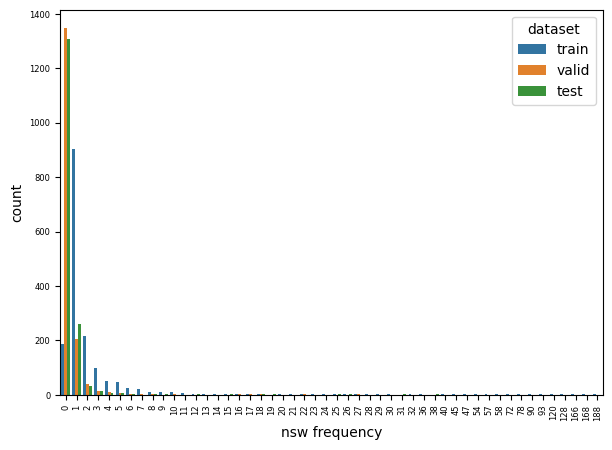

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (7, 5))

sns.countplot(data = df, x = "nsw frequency", hue = 'dataset')
plt.xticks(rotation = 90, fontsize = 6)
plt.yticks(fontsize = 6)